# Math 228b Problem Set 6
## Numerical solution to differential equations
Håkon Olav Torvik

UC Berkeley
(April 20, 2022)

In this problem set we model traffic flow through a light-regulated intersection, using a finite volume method to solve the differential equation goverining the system. The numerical flux is approximated with 2 different schemes, Roe and Godunov. I will not repeat the equations here.

# Part 1

First I write functions that solve the problem for 1 period, and implements the 2 schemes for the numerical flux function.

In [18]:
using Plots
using LaTeXStrings

umax = 1
pmax = 1

u(p) = umax * (1 - p / pmax)
f(p) = p * u(p)

f (generic function with 1 method)

In [36]:
function initialize()
    pL0 = 0.8                   # initial density before light
    N = 400                     # number of cells -1
    T = 2                       # length of 1 period
    dx = 4 / N                  # spatial resolution 
    dt = 0.8 * dx / umax        # temporal resolution
    C = dt / dx                 # update ratio, dt/dx
    nT = Int(T / dt)            # number of time points per period
    x = (0:N) .* dx .- 2        # spatial domain

    p = zeros(N+1, nT)          # car density at all points in space and time
    p[:, 1] = pL0 .* (x .< 0)   # initialize for t=0
    return p, x, dt, C
end

initialize (generic function with 1 method)

In [20]:
"""
    F = Flux(p, method)

Numerical flux function, using either Roe or Godunov scheme
Arguments:
    p, array: density at cell midpoints x_i
    method, string: method
Returns:
    F, array: numerical flux at next cell edges, x_(i+1/2)
"""
function Flux(p, method)
    if method == "Roe"
        a = @. umax * (1 - (p[1:end-1] + p[2:end]) / pmax)
        return @. (f(p[1:end-1]) + f(p[2:end]) - abs.(a)*(p[2:end] - p[1:end-1])) / 2

    elseif method == "Godunov"
        F = zeros(length(p) - 1)
        for i = 1:length(p)-1
            fp = [f(p[i]), f(p[i+1])]
            if p[i] < p[i+1]
                # f(p) is concave, local minimum is at endpoint of interval
                F[i] = minimum(fp)  
            else
                # if interval contains global max, this is also local max
                if p[i+1] < 0.5 < p[i]  
                    F[i] = f(0.5)
                else  # otherwise local max is at endpoint of interval
                    F[i] = maximum(fp)
                end
            end
        end
        return F
    end
end

Flux

In [35]:
"""
    dq = run_period!(p, C, pL; method, light_fn, recorder)

Simulates traffic flow for a whole period, 
    updating the density matrix in place
Arguments:
    p, 2d-array: matrix with density in space and time
    C, float: dt/dx
    pL, float: left boundary condition
    method, string: Either Roe or Godunov
    light_fn, function: controlls traffic lights. 
        Sets the numerical flux to 0, where there is a red light.
        Defaults to doing nothing
    recorder, int: Index at which to measure flow
Returns:
    dq, float: average flow measured at index recorder
"""
function run_period!(p, C, pL; method="Godunov", light_fn=((F,t)->nothing), recorder=2)
    nT = size(p, 2)

    for t = 1:nT - 1
        F = Flux(p[:, t], method)  # get numerical fluxes
        light_fn(F, t)  # set light to red when and where appropriate

        p[2:end-1, t+1] .= p[2:end-1, t] - C * (F[2:end] - F[1:end-1])
        p[[1, end],t+1] .= [pL, 0]  # Characterisitc boundary conditions 
    end
    sum(f.(p[recorder, :])) / nT  # calculate average traffic flow during period
end


run_period!

For part 1, I run the simulation for 1 period using both Roe and Godunov scheme. I plot the final state at $T=2$, along with the initial state, in the same figure. This is seen in the output of the cell below.

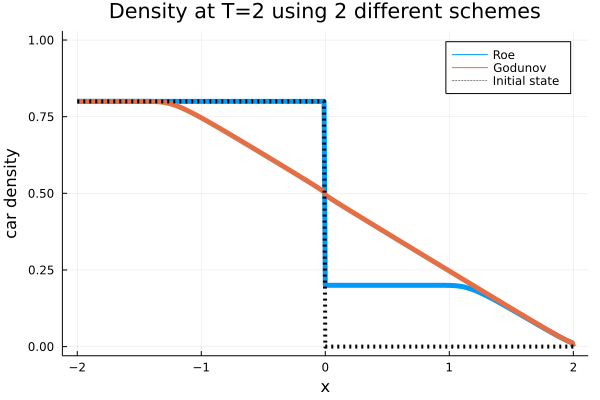

In [33]:
function part1()
    p_roe, x, dt, C = initialize()
    p_god, _, __, _ = initialize()
    pL = p_roe[1, 1]
    
    run_period!(p_roe, C, pL; method="Roe")
    run_period!(p_god, C, pL; method="Godunov")

    # @gif for t = 1:size(p_roe, 2)
    #     P = plot(x, p_roe[:, t], title="t = $(round(t*dt, digits=4))", color="blue", st=:scatter, markersize=2, ylim=[0, 1])
    #     plot!(x, p_god[:, t], title="t = $(round(t*dt, digits=4))", color="red", st=:scatter, markersize=2, ylim=[0, 1])
    # end every 1
    
    plot(x, p_roe[:, end], lw=5, label="Roe")
    plot!(x, p_god[:, end], lw=5, label="Godunov")
    plot!(x, p_roe[:, 1], lw=4, color="black", linestyle=:dot, label="Initial state")
    plot!(title="Density at T=2 using 2 different schemes", ylim=[0, 1], xlabel="x", ylabel="car density")
end
part1()
    

Using the Roe scheme, the initial shock stays. This is violating entropy. The Godunov scheme is smoothing it out, preserving entropy. For the next simulations, only the physically plausible Godunov scheme will be used.

# Part 2

First I make a function that makes it easy to run multiple periods, and controll traffic lights.

In [37]:
"""
    dq = run_til_convergence!(f, p; tol, maxiter)

Runs the simulation several times, using the last state 
    of the previous run as the first of the next. Runs until the 
    average traffic flow during the period is constant, up to tolerance. 
    Will half if this takes more then maxiter iterations.
Arguments:
    f, function: function that simulates p for one period. Updates p in place
    p, array: density to be simulated over.
    tol, float: smallest change in average traffic flow before halting.
    maxiter, int: if reach, halt even though convergence is not attained.
Returns:
    dq, float: average traffic flow during last period
Updates p in place, such that after, the latest period will be saved
"""
function run_til_convergence!(run, p; tol=1e-6, maxiter=10)
    converged = false
    dq_prev = -1
    dq = -1
    iters = 0

    while !converged
        iters += 1
        dq = run(p)
        ddq = abs(dq - dq_prev)
        if ddq < tol
            converged = true
        end
        if iters > maxiter - 1
            println("DID NOT CONVERGE AFTER $(maxiter) ITERS")
            converged = true
        end
        dq_prev = dq
        p[:, 1] .= p[:, end]
    end
    return dq
end

run_til_convergence!

In [24]:
"""
    light!(F, T, x, delay)

Sets F to zero at indices x, when T < 1. 
When a delay is used, its length must equal length of x, 
such that each light is has its own delay.
sin(pi*(T-delay)) is then used to ensure that this works periodically.
Arguments:
    F, array: Fluxes to be changed
    T, float: current time
    x, array: indices to change
    delay, (array, float): delay before changing a light
Returns:
    nothing, updates F in place
"""
function light!(F, T, x, delay=0)  
    @. F[x] *= (sin(pi * (T - delay))) < 0
end

light!

Now i place a traffic light at $x=0$, which is red for $0< t < 1$, and green for $1< t < 2$. After each period of length $T=2$, I calculate the average traffic flow during the period, and repeat until this does not chage.

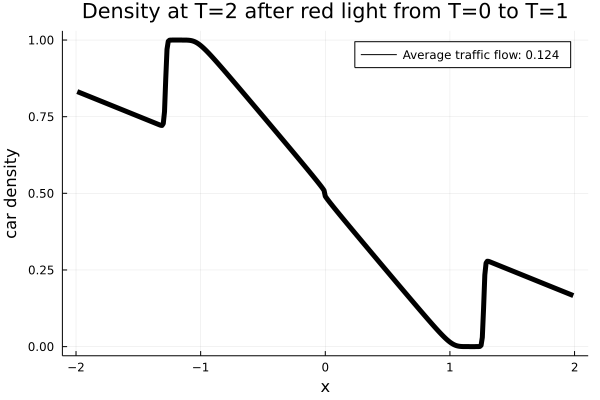

In [43]:
function part2()
    p, x, dt, C = initialize()  # get initial conditions
    pL = pmax / 2
    light_pos = [0]  # place traffic light at x=0
    light_idx = findall(x->x in light_pos, x) .- 1  # -1 to capture F_(i-1/2)

    light(F, t) = light!(F, t*dt, light_idx)
    run(P) = run_period!(P, C, pL; light_fn=light, recorder=300)

    dq = run_til_convergence!(run, p) 
    
    # @gif for t = 1:size(p, 2)
    #     plot(x, p[:, t], title="t = $(round(t*dt, digits=4))", st=:scatter, markersize=2, ylim=[0, 1])
    # end every 1
   
    P = plot(x[2:end-1], p[2:end-1, end], lw=5, color="black", label="Average traffic flow: $(round(dq, digits=3))")
    plot!(title="Density at T=2 after red light from T=0 to T=1", ylim=[0, 1], xlabel="x", ylabel="car density")
end
part2()


In the figure above, I show the final state of the system. The average traffic flow when the system had stabilized was $\dot{q}=0.124$.

# Part 3

For the last part, I now have a traffic light at $x=0$, and one at $x=0.15$. The first light turns red and green in the same was as in part 2. The second light follows, with a delay of $\tau$.

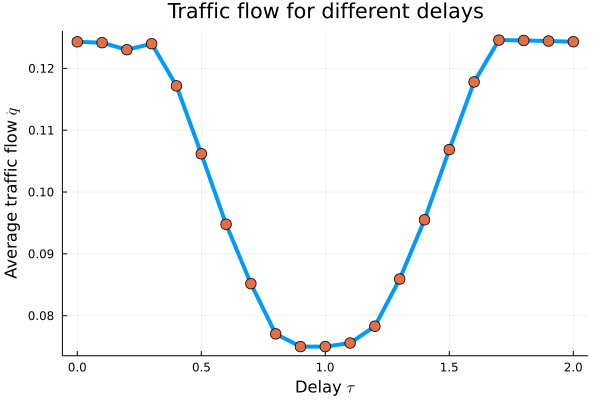

In [49]:
function part3()
    dqs = []
    k = (0:0.5:10)
    taus = 0.2 .* k

    for tau in taus
        p, x, dt, C = initialize()  # get initial conditions
        pL = pmax / 2
        light_pos = [0, 0.15]  # place traffic light at x=0
        light_idx = findall(x->x in light_pos, x) .- 1  # -1 to capture F_(i-1/2)

        light(F, t) = light!(F, t*dt, light_idx, [0, tau])  
        run(P) = run_period!(P, C, pL; light_fn=light, recorder=300)

        push!(dqs, run_til_convergence!(run, p; maxiter=50))
        
        # if tau == 0.6  # animate
        #     @gif for t = 1:size(p, 2)
        #         P = plot(x, p[:, t], title="t = $(round(t*dt, digits=4))", st=:scatter, markersize=2, ylim=[0, 1])
        #     end every 1
            # plot(x[2:end-1], p[2:end-1, end], lw=5, color="black", label="Average traffic flow: $(round(dq, digits=3))")
            # plot!(title="Density at T=2 after red light from T=0 to T=1", ylim=[0, 1], xlabel="x", ylabel="car density")
        # end
    end
    plot(taus, dqs, st=[:line, :scatter], 
            markersize=6, lw=4, 
            title="Traffic flow for different delays", 
            xlabel="Delay " * L" \tau", 
            ylabel="Average traffic flow " * L" \dot{q}", 
            label="")
end
part3()

In the figure above, I have plotted the average traffic flow as function of light delay $\tau \in (0, T)$. When the lights are close to being in phase, there is not much impact on the traffic flow through the intersections. When they are in counter phase however, there is a significant drop in traffic flow. This seems to be close to symmetric, i.e. it doesn't matter if the second light turns a little before or after the first.

A delay of $\tau=1$ is the optimal delay for interupting traffic.

<!---
![gif](./tmp.gif)
Animation of density when $\tau=0.6$.
---> 